In [384]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
import time
from sklearn.model_selection import cross_val_score,train_test_split, GridSearchCV
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, accuracy_score,f1_score,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer

# EXAMEN

## EJERCICIO 1

Carga el conjunto de datos Iris (el de las flores según la anchura y la altura del pétalo y del sépalo) desde scikit-learn (se ha hecho en algún ejercicio).

Explora los datos visualmente utilizando gráficos: representa la distribución de cada variable (todas las de X e y), diagramas de cajas de cada variable (todas las de X) y la matriz de correlaciones para entender las relaciones entre las características. ¿Qué puedes deducir?

Divide el conjunto de datos en entrenamiento y prueba, estratificando por el tipo de flor.

Prepara los datos mediante una pipeline.

Entrena y evalúa un clasificador Random Forest utilizando validación cruzada. ¿Qué métrica has usado para evaluar el modelo y por qué? ¿Cuál es el mejor y el peor error que consigues?

Optimiza el número de árboles, ¿cuál es el mejor valor?

Evalúa el rendimiento del modelo optimizado en el conjunto de prueba.

Guarda el modelo en un fichero y cárgalo desde un fichero .py que pida 4 datos para una nueva flor (anchura del pétalo, longitud del pétalo, anchura del sépalo y longitud del sépalo) y prediga de que clase es la flor (quiero que me de un nombre, no un número y hay que controlar las excepciones).

In [385]:
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

### Explorar datos

In [386]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [387]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [388]:
X.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [389]:
y.head(5)

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [390]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 150 entries, 0 to 149
Series name: target
Non-Null Count  Dtype
--------------  -----
150 non-null    int64
dtypes: int64(1)
memory usage: 1.3 KB


In [391]:
y.describe()

count    150.000000
mean       1.000000
std        0.819232
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: target, dtype: float64

In [392]:
df_iris = X.copy()
df_iris['target'] = y
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


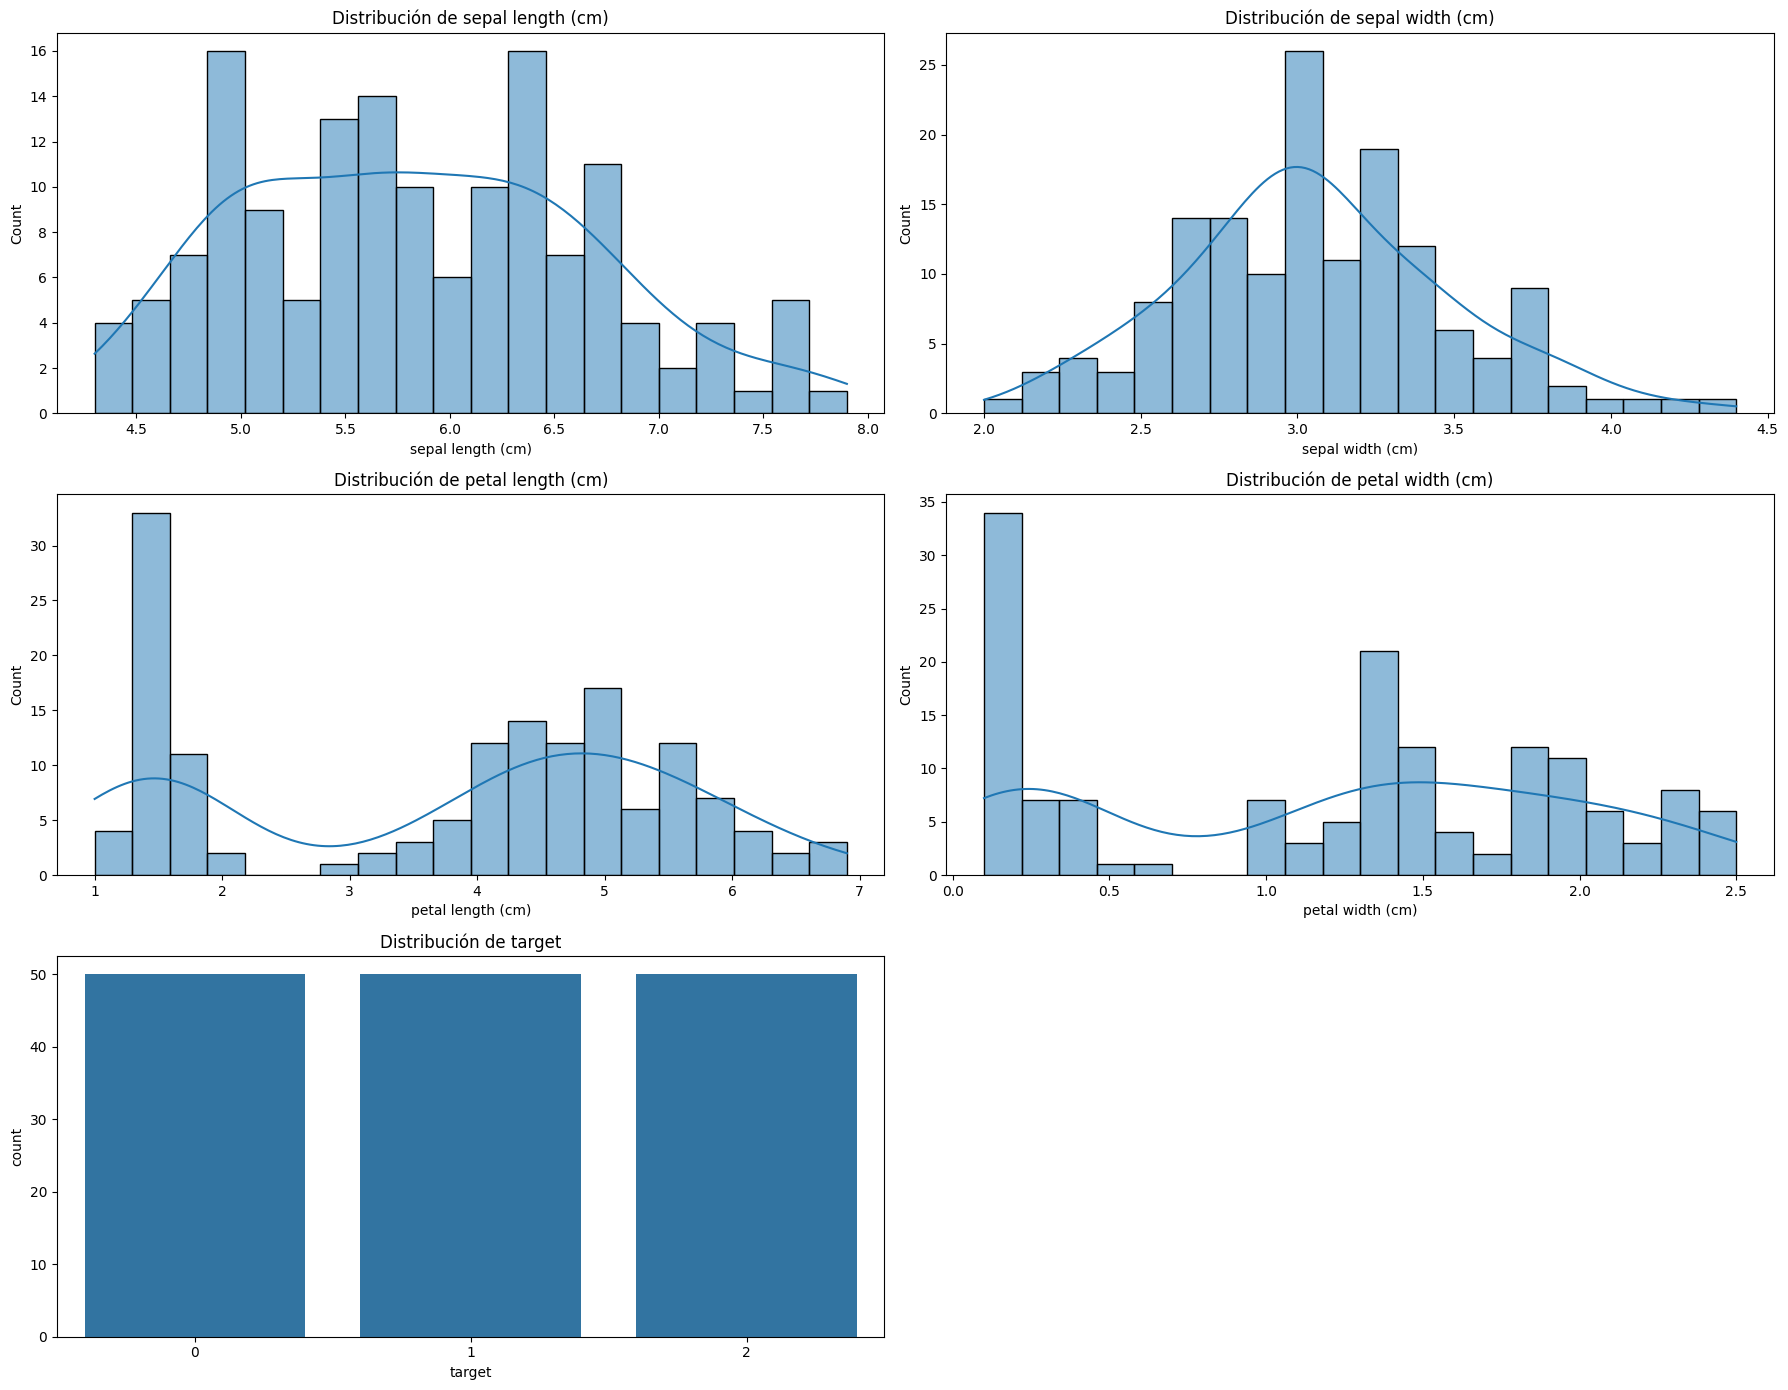

In [393]:
plt.figure(figsize=(18, 14))

# Crear una lista con los nombres de las características
features = df_iris.columns

# Graficar cada una de las características en un subplot
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  
    if feature == 'target':  
        sns.countplot(x=df_iris[feature])
    else: 
        sns.histplot(df_iris[feature], kde=True, bins=20)
    plt.title(f'Distribución de {feature}')

# Ajustar el layout
plt.tight_layout()
plt.show()

<Axes: >

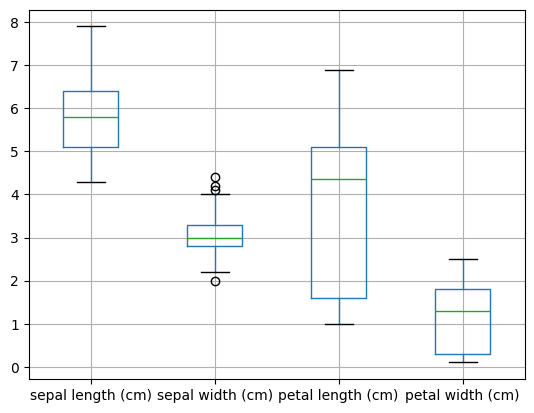

In [394]:
X.boxplot()

In [395]:
matriz_correlacion = df_iris.corr(numeric_only=True)
matriz_correlacion['target'].sort_values(ascending=False)

target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
Name: target, dtype: float64

In [396]:
matriz_correlacion.style.background_gradient()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
sepal length (cm),1.000000,-0.117570,0.871754,0.817941,0.782561
sepal width (cm),-0.117570,1.000000,-0.428440,-0.366126,-0.426658
petal length (cm),0.871754,-0.428440,1.000000,0.962865,0.949035
petal width (cm),0.817941,-0.366126,0.962865,1.000000,0.956547
target,0.782561,-0.426658,0.949035,0.956547,1.000000


Podemos ver que los datos que tienen mas correlacion con el target son la longitud del petalo y la anchura del petalo,
despues seria la longitud del sepalo y el que menos correlacion tiene es la anchura del sepalo.

### Dividir datos

Como ,en este ejercicio, no pides la cantidad de datos para cada conjunto de datos, lo he dividido en 80% para entrenamiento y 20% para pruebas.

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

### Preparar datos

In [398]:
pipeline=make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

### Entrenamiento y evaluacion

In [399]:
rand_cl=make_pipeline(
    pipeline,
    RandomForestClassifier(n_estimators=150,random_state=42))

rand_cl.fit(X_train,y_train)

resultados=cross_val_score(rand_cl,X_train,y_train,cv=5,scoring='f1_macro')
print(resultados)

[0.91534392 0.95816993 0.95816993 0.95816993 0.95816993]


Utilizo como metrica f1 porque evalua el equilibrio entre precision y sensibilidad

In [400]:
print(f"El peor resultado es: {resultados.min()}") 
print(f"El mejor resultado es: {resultados.max()}") 

El peor resultado es: 0.9153439153439153
El mejor resultado es: 0.9581699346405229


### Optimizacion y evaluacion

In [401]:
parametros = {
    "randomforestclassifier__n_estimators": [5, 25, 50, 100, 150, 200, 250, 300]
}

grid_search = GridSearchCV(rand_cl, parametros, scoring="f1_macro", cv = 5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pipeline',
                                        Pipeline(steps=[('simpleimputer',
                                                         SimpleImputer()),
                                                        ('standardscaler',
                                                         StandardScaler())])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=150,
                                                               random_state=42))]),
             param_grid={'randomforestclassifier__n_estimators': [5, 25, 50,
                                                                  100, 150, 200,
                                                                  250, 300]},
             scoring='f1_macro')

In [402]:
grid_search.best_params_

{'randomforestclassifier__n_estimators': 5}

In [403]:
resultado_optimizado=f1_score(y_test,grid_search.predict(X_test),average='macro')
print(f"Los resultados del modelo en el conjunto de pruebas es: {resultado_optimizado}")

Los resultados del modelo en el conjunto de pruebas es: 0.9333333333333332


### Guardar el modelo

In [404]:
joblib.dump(grid_search.best_estimator_, "modelo_ej1.pkl")
print("El mejor modelo ha sido guardado como 'modelo_ej1.pkl'.")

El mejor modelo ha sido guardado como 'modelo_ej1.pkl'.


## EJERCICIO 2

En este ejercicio, trabajarás con un conjunto de datos de pruebas creados (ejercicio2.csv). 

Tu objetivo es construir un modelo de regresión que pueda predecir con precisión la variable dependiente y a partir de las variables independientes x1 y x2. 

Deberás:
* Cargar los datos
* Visualizar gráficamente los datos (x1 respecto a y e x2 respecto a y)
* Dividir los datos en conjunto de entrenamiento y pruebas
* Probar diferentes modelos de regresión polinómica (PolynomialFeatures + ), hasta ver cuál es el mejor degree (y explicarlo gráficamente y por medida del error en los conjuntos de entrenamiento y pruebas), no hace falta que uses validación cruzada. ¿Qué medición has usado para evaluar el modelo y por qué? ¿cuál es el mejor degree?
* Probar ahora con Elastic Net, optimizando los hiperparámetros con búsqueda exhaustiva, ¿ha mejorado con esta regularización? ¿cuáles son los mejores datos para los hiperparámetros?

Pista para hacer la gráfica:

´´´´´´

    degrees = [1, 2, 3, 4, 5]
    train_errors = []
    test_errors = []

    for degree in degrees:
        model = Pipeline([
            XXX
        ])
        model.fit(XXX)

        y_train_pred = model.predict(XXX)
        y_test_pred = model.predict(XXX)
        train_error= XXX #medir el error en el conjunto de entrenamiento
        test_error= XXX #medir el error en el conjunto de test
        train_errors.append(train_error)
        test_errors.append(test_error)
        print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

    plt.figure(figsize=(10, 6))
    plt.plot(degrees, train_errors, label='Train Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Mean Squared Error')
    plt.title('Error vs. Degree of Polynomial')
    plt.legend()
    plt.show()

´´´´´´

### Cargar datos

In [405]:
df_ej2 = pd.read_csv("ejercicio2.csv")
df_ej2

,x1,x2,y
0,0.488135,3.115185,-91.197936
1,2.151894,-0.239160,-44.928270
2,1.027634,0.231560,-5.347793
3,0.448832,-2.494794,78.026649
4,-0.763452,1.050430,2.176875
...,...,...,...
1995,2.912816,-1.503606,-54.720299
1996,2.211981,-0.651264,-39.841896
1997,-0.198922,3.300029,-104.087315
1998,1.438640,4.328062,-303.627063


### Explorar los datos

In [406]:
df_ej2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      2000 non-null   float64
 1   x2      2000 non-null   float64
 2   y       2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


In [407]:
df_ej2.describe()

,x1,x2,y
count,2000.000000,2000.000000,2000.000000
mean,0.036358,-0.054283,48.740011
std,2.949828,2.867048,277.069557
min,-4.996327,-4.999276,-742.189025
25%,-2.507467,-2.430828,-121.433051
50%,0.011938,-0.170823,17.398991
75%,2.668045,2.467225,215.989595
max,4.998086,4.999640,1062.625985


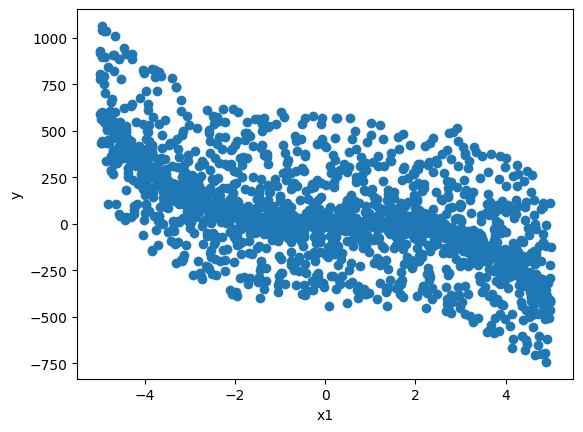

In [408]:
# grafico x1 respecto a y
plt.scatter(x = df_ej2["x1"], y = df_ej2["y"])
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

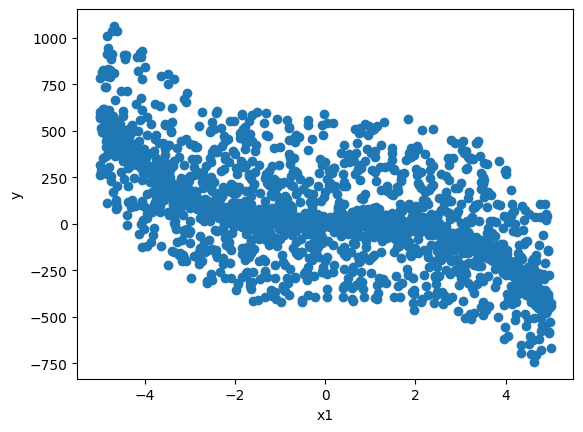

In [409]:
# grafico x2 respecto a y
plt.scatter(x = df_ej2["x2"], y = df_ej2["y"])
plt.xlabel("x1")
plt.ylabel("y")
plt.show()

### Dividir los datos

In [410]:
X=df_ej2.drop('y', axis=1)
y=df_ej2['y']

Como en el ejercicio anterior pondremos el 80% de los datos para el entrenamiento y el 20% para pruebas

In [411]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

### Entrenamiento y evaluacion

Grado: 1, error entrenamiento:113.1529401826091 , error test: 108.9122096596528
Grado: 2, error entrenamiento:107.76582805737765 , error test: 107.37403063517353
Grado: 3, error entrenamiento:9.99032885893734 , error test: 10.373008186794989
Grado: 4, error entrenamiento:9.980148252895184 , error test: 10.349780872532905
Grado: 5, error entrenamiento:9.973507409100522 , error test: 10.353313124181883


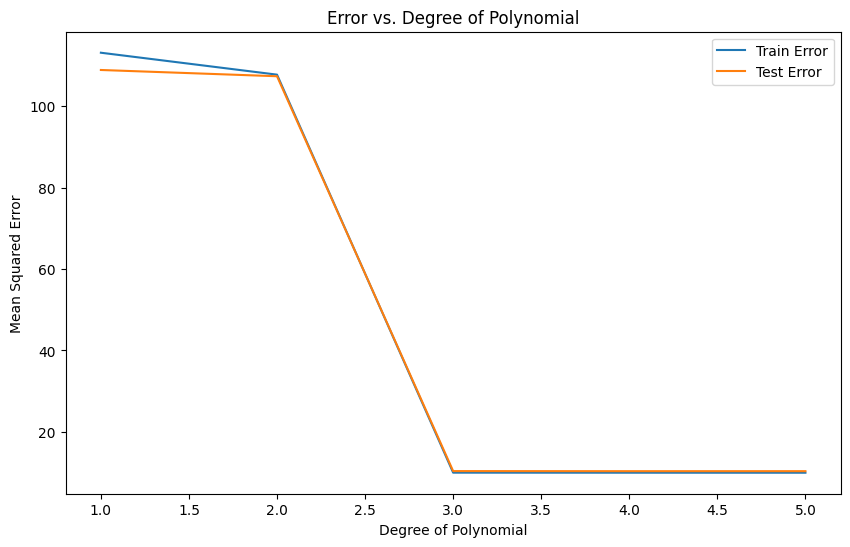

In [412]:
degrees = [1, 2, 3, 4, 5]
train_errors = []
test_errors = []


for degree in degrees:
    model = make_pipeline(
        PolynomialFeatures(degree=degree),
        StandardScaler(),
        LinearRegression()
    )
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_error= np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_error= np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_errors.append(train_error)
    test_errors.append(test_error)
    print("Grado: {}, error entrenamiento:{} , error test: {}".format(degree, train_error,test_error))

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error')
plt.plot(degrees, test_errors, label='Test Error')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Error vs. Degree of Polynomial')
plt.legend()
plt.show()

La medicion que he usado es la raiz del error cuadratico medio porque los errores graves tienen una penalización mayor que con MAE y tiene un orden de magnitud cercano a los valores de y.

El Mejor grado es el que tenga menos RMSE por lo que en mi caso es el 4 para el conjunto de prueba.

In [413]:
parametros_eln = {
    "elasticnet__alpha": [0.00001,0.0001, 0.001, 0.1, 1, 10],
    "elasticnet__l1_ratio": [0.01, 0.25, 0.5, 0.75, 0.99],
    "elasticnet__max_iter": [100, 150, 200, 250, 300, 1000, 2000]
}

modelo_eln = make_pipeline(
    StandardScaler(),
    ElasticNet(random_state=5)
)

# Antes he utilizado el RECM pero aquí el scoring es el valor negativo del RECM, ya que cuanto menor sea el RECM mejor, pero como Sklearn tiene la filosofía cuanto mayor el score mejor, se utiliza el negativo.
grid_search_eln = GridSearchCV(modelo_eln, parametros_eln, scoring="neg_root_mean_squared_error")
grid_search_eln.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('elasticnet',
                                        ElasticNet(random_state=5))]),
             param_grid={'elasticnet__alpha': [1e-05, 0.0001, 0.001, 0.1, 1,
                                               10],
                         'elasticnet__l1_ratio': [0.01, 0.25, 0.5, 0.75, 0.99],
                         'elasticnet__max_iter': [100, 150, 200, 250, 300, 1000,
                                                  2000]},
             scoring='neg_root_mean_squared_error')

In [414]:
np.sqrt(mean_squared_error(y_test, grid_search_eln.best_estimator_.predict(X_test)))

108.89481220204023

Comprobamos que el modelo no ha mejorado con respecto al anterior ya que el mejor de los anteriores da 107.117964109448 y este da 108.89481220204023

In [415]:
# Mejores parametros
grid_search_eln.best_params_

{'elasticnet__alpha': 0.001,
 'elasticnet__l1_ratio': 0.5,
 'elasticnet__max_iter': 100}

## EJERCICIO 3

Queremos predecir la calidad del vino (quality) a partir del resto de características.

Carga el conjunto de datos winequality.csv, explora los datos y divide el conjunto de datos en entrenamiento y pruebas (10% para las pruebas).

Crea una pipeline para preparar los datos y aplicar un algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Crea una pipeline para preparar los datos y aplicar PCA que explique al menos el 95% de la varianza, aplica esta pipeline al conjunto de entrenamiento y al conjunto de pruebas.

Muestra cuantas dimensiones tenías al principio y cuantas después de aplicar PCA.

Aplica a los datos obtenido de aplicar PCA el algoritmo de máquinas de vector soporte, entrena el modelo (guarda el tiempo que tardas en entrenar el modelo) y evalúa el modelo en el conjunto de pruebas (no hace falta que pruebes con diferentes hiperparámetros...)

Compara el error y el tiempo empleado en los dos modelos (sin pca y con pca) e interpreta el resultado.


### Cargar datos

In [416]:
#Exploramos el archivo CSV y comprobamos que se delimita con ;

df_vino = pd.read_csv("winequality.csv", delimiter=";")
df_vino

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### Explorar datos

In [417]:
df_vino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [418]:
df_vino.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


### Separamos los datos

In [419]:
X=df_vino.drop('quality',axis=1)
y=df_vino['quality']

In [420]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.1)

### Preparar datos

In [421]:
svc=make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    SVC()
)


### Entrenamiento y evaluacion

In [422]:
%time svc.fit(X_train,y_train)

CPU times: user 6.09 ms, sys: 3.46 ms, total: 9.54 ms
Wall time: 8.53 ms


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()), ('svc', SVC())])

In [423]:
precision_score(y_test, svc.predict(X_test), average="macro", zero_division=0.0)

0.31945197624809274

### PCA

In [424]:
PCA = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95)
)

# Aplicamos la reduccion a los conjuntos de entrenamiento y prueba.
X_train_pca = PCA.fit_transform(X_train)
X_test_pca = PCA.transform(X_test)

In [425]:
print(f"Conjunto de entrenamiento: {X_train.shape[1]} dimensiones")


Conjunto de entrenamiento: 11 dimensiones


In [426]:
print(f"Conjunto de entrenamiento con PCA: {PCA.named_steps["pca"].n_components_} dimensiones")

Conjunto de entrenamiento con PCA: 8 dimensiones


In [427]:
%time svc.fit(X_train_pca,y_train)

precision_score(y_test, svc.predict(X_test_pca), average="macro", zero_division=0.0)

CPU times: user 7.3 ms, sys: 303 μs, total: 7.6 ms
Wall time: 6.79 ms


0.28949009089196004

Viendo los resultado de los dos modelos podemos observar que SVC con PCA a tardado 2 segundo menos en entrenar y la precision es mayor.
Por lo que afirmamos que con este dataset y utilizando PCA se consiguen mejores resultados que sin PCA.

## EJERCICIO 4

Una empresa de coches ha sacado un nuevo modelo al mercado. Le ha preguntado a una red social quién ha comprado el producto, recaudando el sexo, la edad y el salario de cada uno de ellos. Ahora queremos construir un modelo que nos permita determinar con estos atributos si la persona comprará el producto o no, para tomar medidas en función de la respuesta para que lo acabe comprando.

Los datos están en el csv

### RECOPILACIÓN Y RECOLECCIÓN DE LOS DATOS

####  OBTENER LOS DATOS

In [428]:
df_coches = pd.read_csv("compras.csv")
df_coches

,Identificador,Sexo,Edad,Salario,Compra
0,15624510,Hombre,19,19000,0
1,15810944,Hombre,35,20000,0
2,15668575,Mujer,26,43000,0
3,15603246,Mujer,27,57000,0
4,15804002,Hombre,19,76000,0
...,...,...,...,...,...
395,15691863,Mujer,46,41000,1
396,15706071,Hombre,51,23000,1
397,15654296,Mujer,50,20000,1
398,15755018,Hombre,36,33000,0


#### EXPLORAR LOS DATOS 
Con exhaustividad: datos estadísticos, gráficos, correlaciones... e indicar las deduciones a las que llegas

In [429]:
df_coches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Identificador  400 non-null    int64 
 1   Sexo           400 non-null    object
 2   Edad           400 non-null    int64 
 3   Salario        400 non-null    int64 
 4   Compra         400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


In [430]:
df_coches.describe()

,Identificador,Edad,Salario,Compra
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


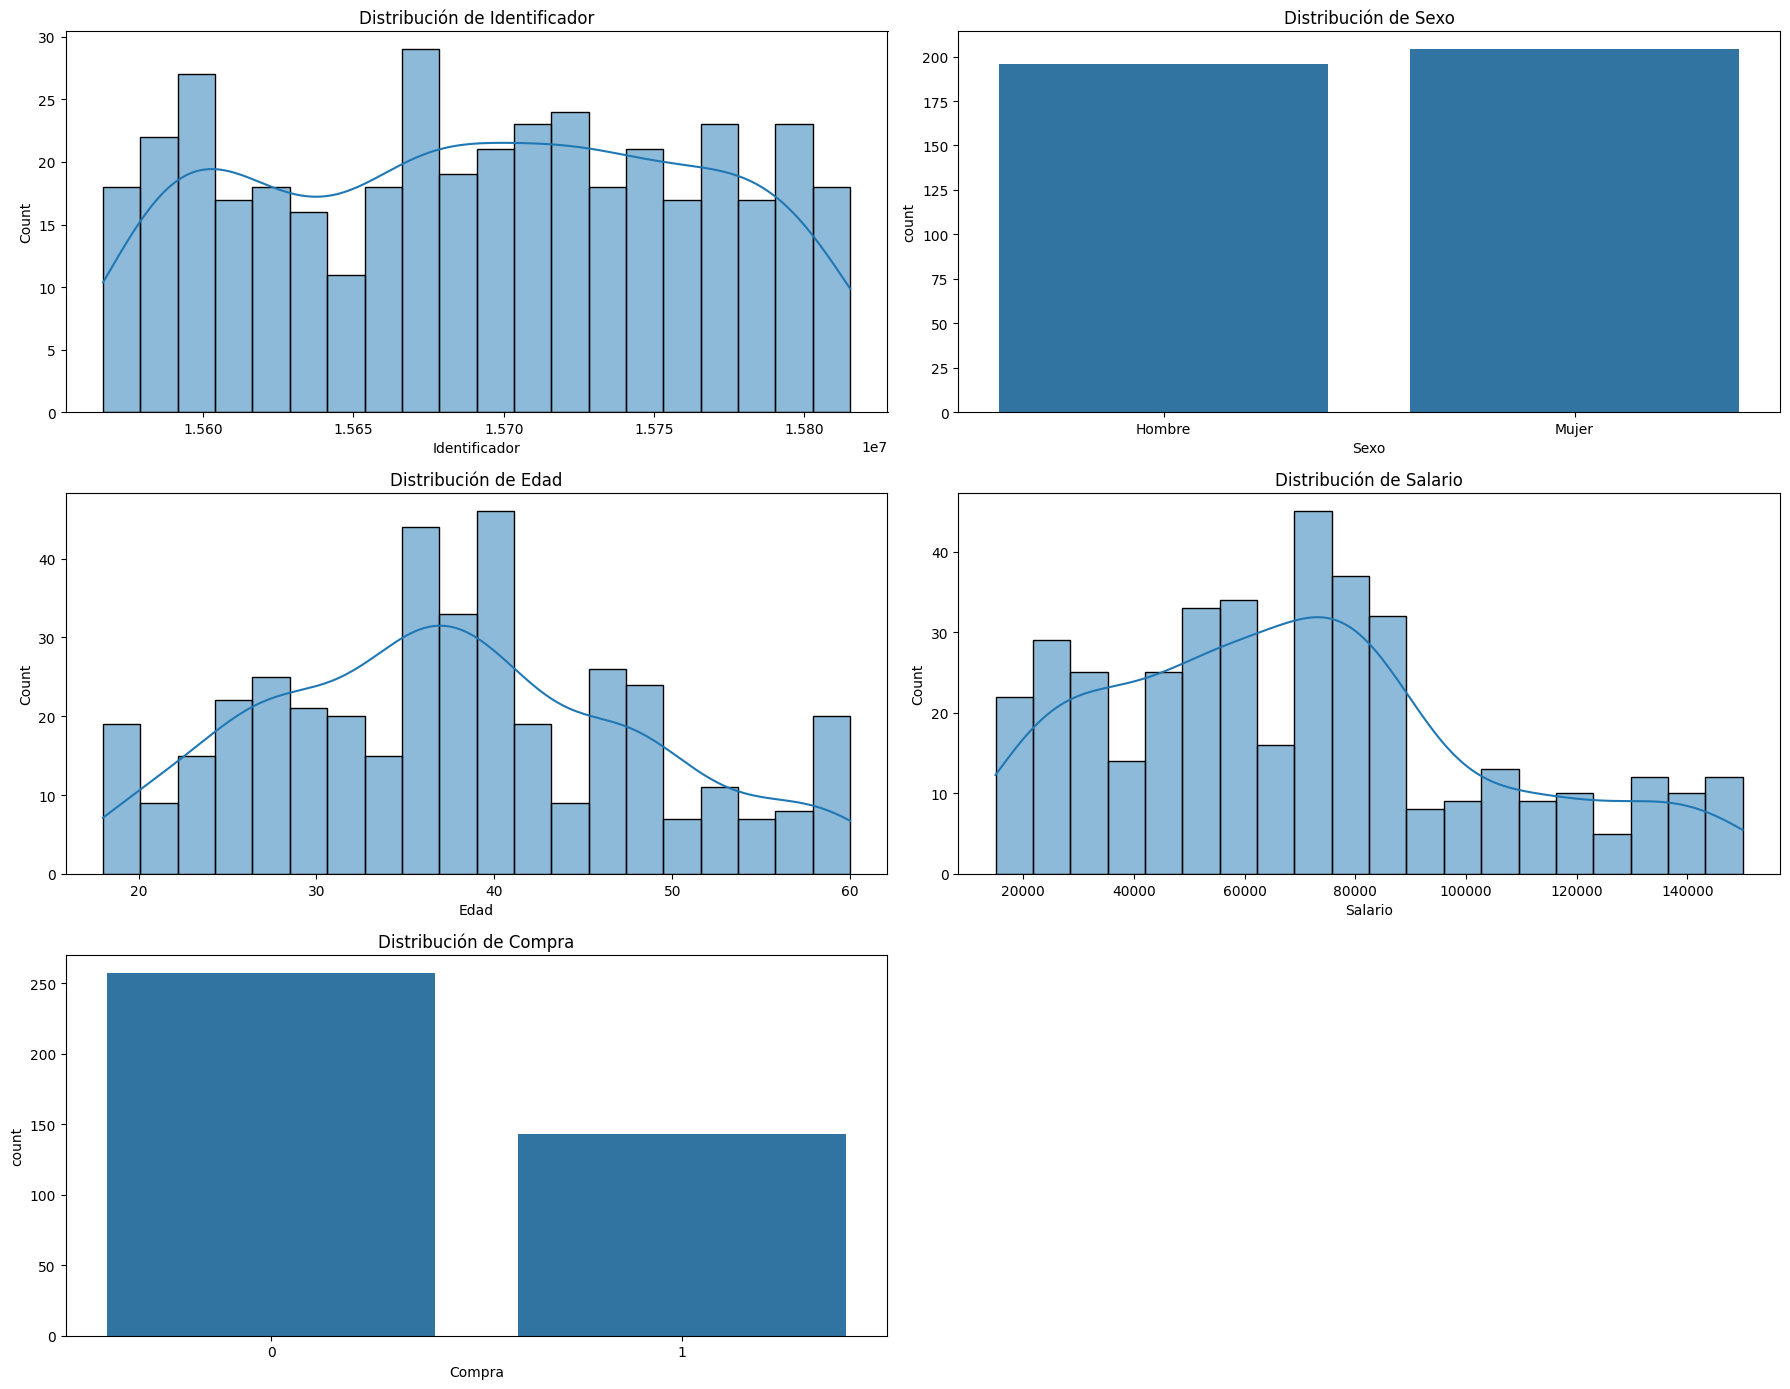

In [431]:
plt.figure(figsize=(18, 14))

categoricas=["Sexo","Compra"]

features = df_coches.columns

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  
    if feature in categoricas:  
        sns.countplot(x=df_coches[feature])
    else:  
        sns.histplot(df_coches[feature], kde=True, bins=20)
    plt.title(f'Distribución de {feature}')

# Ajustar el layout
plt.tight_layout()
plt.show()

In [432]:
matriz_correlacion = df_coches.corr(numeric_only=True)
matriz_correlacion['Compra'].sort_values(ascending=False)

Compra           1.000000
Edad             0.622454
Salario          0.362083
Identificador    0.007120
Name: Compra, dtype: float64

In [433]:
matriz_correlacion.style.background_gradient()

,Identificador,Edad,Salario,Compra
Identificador,1.000000,-0.000721,0.071097,0.007120
Edad,-0.000721,1.000000,0.155238,0.622454
Salario,0.071097,0.155238,1.000000,0.362083
Compra,0.007120,0.622454,0.362083,1.000000


Viendo los graficos podemos ver que hay mas mujeres que hombre (pero estan casi iguales), que la mayoria de las personas tienen entre 35 y 40 años, la grafica de salarios tiene una media muy frecuente cerca de los 70000 pero a partir de  los 80000 no hay mucha gente asi que deducimos que la gente tiene sueldo por dejabo de la media y hay mas gente que no ha comprado el coche en comparacion a la que si lo ha comprado.

Respecto a la matriz de correlacion, podemos observar que el identificador no tiene casi nada de relacion con el resto de variables por lo que la eliminaremos (No aportara nada a nuestro modelo)
Las mas correlacionada con la compra es la edad.

#### DIVIDIR LOS DATOS EN CONJUNTO DE ENTRENAMIENTO Y PRUEBAS

In [434]:
df_coches.drop('Identificador',axis=1)
X=df_coches.drop('Compra',axis=1)
y=df_coches['Compra']

In [435]:
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.2)

#### PREPARAR LOS DATOS
Algunas pistas a tener en cuenta (** esto no quiere decir que sólo haya que hacer esto**):
* No usar las características que no sirven
* Tratar los valores nulos (aunque ahora no haya)
* Edad: primeramente convertir en categórica poniendo las siguientes etiquetas y luego aplicar el cambio que procede en las variables categóricas (es para aplicar los diferentes tipos de transformaciones que hay, no porque tenga mucho sentido).
  * 0-20 --> Rango1
  * 20-30 --> Rango 2
  * 30-40 --> Rango 3
  * 40-50 --> Rango 4
  * 50- --> Rango 5

* Salario: aplicar logaritmo (aunque no tenga una cola larga a la derecha) y luego estandarizar

In [436]:
def rango_edad(X):
    bins = [0,20,30,40,50,np.inf]
    labels = ["Rango1","Rango2","Rango3","Rango4","Rango5"]
    # Aplicar pd.cut directamente sobre la columna de edad
    rango_edad = pd.cut(X[:, 0], bins=bins, labels=labels)
    
    return rango_edad.reshape(-1, 1)

def nombre_edad(function_transformer, feature_names_in):
    return ["Edad"]  # feature names out

def encode_sexo(X):
    return np.where(X == 'Hombre', 0, 1)  

def nombre_sexo(function_transformer, feature_names_in):
    return ["Sexo"]  # feature names out

def nombre_salario(function_transformer, feature_names_in):
    return ["Salario"]  # feature names out

pipeline_edad = make_pipeline(
    SimpleImputer(strategy="mean"), 
    FunctionTransformer(rango_edad, feature_names_out=nombre_edad),
    OneHotEncoder(handle_unknown="ignore")
)

pipeline_sexo = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(encode_sexo, feature_names_out=nombre_sexo)
)

pipeline_salario = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(np.log, feature_names_out=nombre_salario, validate=False),
    StandardScaler()
)

preprocessing = ColumnTransformer(
    [
        ("Edad", pipeline_edad, ["Edad"]),
        ("Salario", pipeline_salario, ["Salario"]),
        ("Sexo", pipeline_sexo, ["Sexo"])
    ],
    verbose_feature_names_out=False
)



In [437]:
df_coches_prepared = preprocessing.fit_transform(df_coches)
preprocessing.get_feature_names_out()

array(['Edad_Rango1', 'Edad_Rango2', 'Edad_Rango3', 'Edad_Rango4',
       'Edad_Rango5', 'Salario', 'Sexo'], dtype=object)

In [438]:
df_coches_prepared_fr = pd.DataFrame(
    df_coches_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df_coches.index)
df_coches_prepared_fr

,Edad_Rango1,Edad_Rango2,Edad_Rango3,Edad_Rango4,Edad_Rango5,Salario,Sexo
0,1.0,0.0,0.0,0.0,0.0,-2.095414,0.0
1,0.0,0.0,1.0,0.0,0.0,-2.002996,0.0
2,0.0,1.0,0.0,0.0,0.0,-0.623805,1.0
3,0.0,1.0,0.0,0.0,0.0,-0.115976,1.0
4,1.0,0.0,0.0,0.0,0.0,0.402359,0.0
...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,1.0,0.0,-0.709619,1.0
396,0.0,0.0,0.0,0.0,1.0,-1.751178,0.0
397,0.0,0.0,0.0,1.0,0.0,-2.002996,1.0
398,0.0,0.0,1.0,0.0,0.0,-1.100718,0.0
